In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# add root path (parent folder) to path
import os
import sys
cwd = os.getcwd()
root_path = os.path.abspath(os.path.join(cwd, os.pardir))
sys.path.insert(0, root_path)

import pysta
import stc
import stcl
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
def remove_box():
    # remove top & right box
    # https://stackoverflow.com/a/28720127
    ax=plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

## load raw data in mat and save to npz

Under `data`

```
ln -s ~/data/gaussian_stim_data_mat .
```

```
ln -s ~/data/gaussian_stim_data .
```

In [7]:
# load cell type info
mat_data_path = os.path.join(root_path,'data/gaussian_stim_data_mat')
cell_types = pd.read_csv(os.path.join(mat_data_path, 'cell_type.csv'))
# cell_types['cell type'].replace('-','Unknown', inplace=True)
print(cell_types['cell type'].value_counts())

cell_types
# cell_types.to_csv(os.path.join(data_path, 'cell_type.csv'), index=None)
# cell_types.drop(columns='Unnamed: 0').to_csv(os.path.join(data_path, 'cell_type.csv'), index=None)

ON         42
ON-OFF     34
OFF        17
Unknown    13
Name: cell type, dtype: int64


,channel,cell type
0,ch_12a,ON-OFF
1,ch_13a,ON
2,ch_13b,ON
3,ch_14a,ON
4,ch_14b,ON-OFF
...,...,...
101,ch_86a,OFF
102,ch_86b,OFF
103,ch_87a,ON-OFF
104,ch_87b,ON-OFF


In [8]:
# load all data for a given contrast level


# contrast = 50
# contrast = 80
# contrast = 100

plt.figure(figsize=(13,4))
for i, contrast in enumerate([50, 80, 100]):
    stim, spike_counts, cell_types = pysta.load_gaussian_stim_data_mat(data_path, 'Gaussian', contrast)

    print(stim.shape, spike_counts.shape)
    
    # plot stim
#     plt.figure()
#     plt.imshow(stim[0,:].reshape(8,8), cmap='gray')
#     plt.figure()
#     plt.imshow(stim[1,:].reshape(8,8), cmap='gray')
#     plt.figure()
#     plt.imshow(stim[2,:].reshape(8,8), cmap='gray')

    
    
    sig = np.std(stim)
    print('std=', sig)

    plt.subplot(1,3,i+1)
    plt.hist(stim.ravel())
    plt.title('contrast={}, $\sigma$={:.2f}'.format(contrast, sig))
    plt.xlabel('stim')
    plt.ylabel('count')
    remove_box()
    
    # save to numpy
    filename = os.path.join('data/gaussian_stim_data/contrast{}'.format(contrast))
    np.savez_compressed(filename, stim=stim,  spike_counts=spike_counts)

    # filename = 'fullfield_data/contrast{}.csv'.format(contrast)
    # info.to_csv(filename, index=None)

plt.savefig('stim_info.png')
plt.savefig('stim_info.pdf')

  0%|          | 0/106 [00:00<?, ?it/s]

/Users/yyoo/src/pysta2/data/gaussian_stim_data_mat/Stimulus/StimInfo_8pix_200um_Gaussian_10Hz_15min_contrast50
/Users/yyoo/src/pysta2/data/gaussian_stim_data_mat/Spike_Timestamp/Contrast_50/A1a.mat


 23%|██▎       | 24/106 [00:13<00:54,  1.51it/s]

KeyboardInterrupt: 

<Figure size 936x288 with 0 Axes>

Text(0.5, 1.0, '')

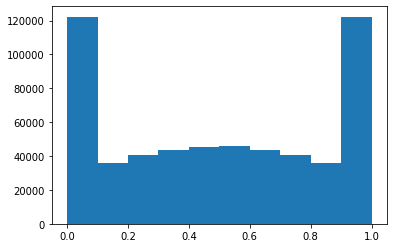

In [9]:
plt.hist(stim.ravel())
plt.title('')

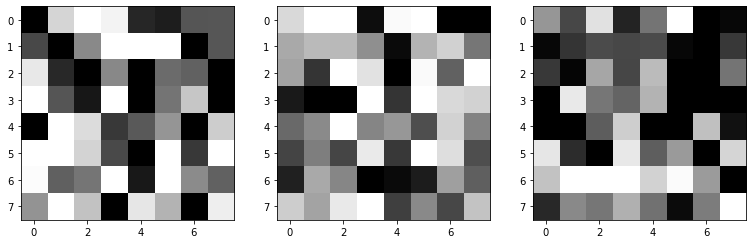

In [10]:
plt.figure(figsize=(13,4))
plt.subplot(131)
plt.imshow(stim[0,:].reshape(8,8), cmap='gray', vmin=0, vmax=1)
plt.subplot(132)
plt.imshow(stim[1,:].reshape(8,8), cmap='gray', vmin=0, vmax=1)
plt.subplot(133)
plt.imshow(stim[2,:].reshape(8,8), cmap='gray', vmin=0, vmax=1)



## load saved data

In [10]:

# contrast = 50
contrast = 80
# contrast = 100

data_path = os.path.join(root_path,'data/gaussian_stim_data')
data = np.load(os.path.join(data_path,'contrast{}.npz'.format(contrast)))

stim = data['stim']
spike_counts = data['spike_counts']

print(stim.shape, spike_counts.shape)

# info = pd.read_csv('fullfield_data/contrast{}.csv'.format(contrast))
# info

(9000, 64) (106, 9000)


In [11]:
# calc STA
tap = 10
stas = list()
sta_min = list()
sta_max = list()
sta_std = list()
num_spikes = list()

for i in range(spike_counts.shape[0]):
    spike_triggered_stim, spike_count = pysta.grab_spike_triggered_stim(stim.T, spike_counts[i,:], tap=tap)
    sta = np.average(np.array(spike_triggered_stim), weights=spike_count, axis=0)
#     plt.plot(sta.T)
    
    num_spikes.append(np.sum(spike_count))
    sta_max.append(np.max(sta))
    sta_min.append(np.min(sta))
    sta_std.append(np.std(sta))    

    stas.append(sta)

In [12]:
spike_triggered_stim.shape, spike_count.shape

((2792, 64, 10), (2792,))

In [15]:
sta_info = cell_types
sta_info['number of spikes'] = num_spikes    
sta_info['sta std'] = sta_std
sta_info['sta max'] = sta_max
sta_info['sta min'] = sta_min

# info
sta_info.to_csv(os.path.join(np_data_path,'contrast{}_sta.csv'.format(contrast)), index=None)

Text(0, 0.5, 'STA std')

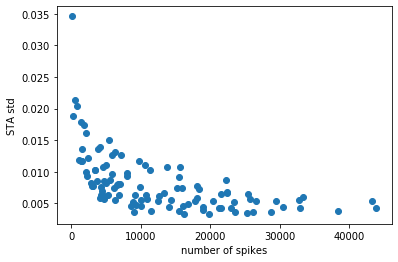

In [16]:
plt.plot(sta_info['number of spikes'], sta_info['sta std'], 'o')
plt.xlabel('number of spikes')
plt.ylabel('STA std')

Text(0, 0.5, 'peak-to-peak')

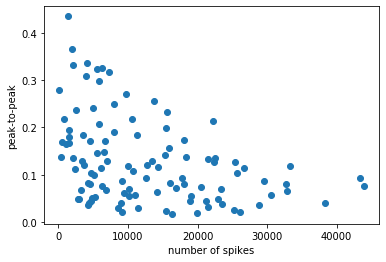

In [17]:
plt.plot(sta_info['number of spikes'], sta_info['sta max'] - sta_info['sta min'], 'o')
plt.xlabel('number of spikes')
plt.ylabel('peak-to-peak')

In [18]:
contrast

80

## plot some STAs

In [19]:
sta_info['sta peak difference'] = sta_info['sta max'] - sta_info['sta min']

sta_info.sort_values(by='sta peak difference', ascending=False).head()

,channel,cell type,number of spikes,sta std,sta max,sta min,sta peak difference
70,ch_51a,Unknown,1397,0.017934,0.848836,0.414161,0.434676
52,ch_41b,ON,1887,0.017451,0.827700,0.461734,0.365966
68,ch_48d,ON,4152,0.013960,0.777201,0.440824,0.336378
87,ch_71b,OFF,2130,0.016150,0.730430,0.398501,0.331928
51,ch_41a,ON,6283,0.013079,0.724389,0.398520,0.325869


channel                   ch_41b
cell type                     ON
number of spikes            1887
sta std                0.0174511
sta max                   0.8277
sta min                 0.461734
sta peak difference     0.365966
Name: 52, dtype: object

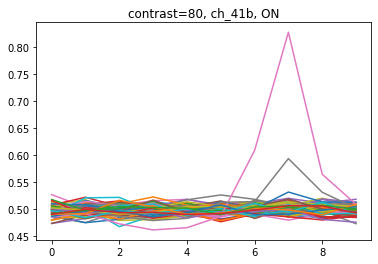

In [20]:
# ch_idx = 13
# ch_idx = 14
# ch_idx = 32
ch_idx = 52

sta = stas[ch_idx]

plt.plot(sta.T)
plt.title('contrast={}, {}, {}'.format(contrast, sta_info.iloc[ch_idx]['channel'], sta_info.iloc[ch_idx]['cell type']))
sta_info.iloc[ch_idx]

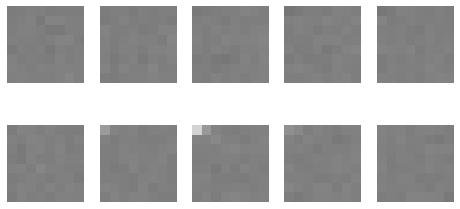

In [21]:
pysta.plot_stim_slices(sta)

In [22]:
def grab_spike_triggered_stim(stim, spike, tap):

    num_time_bin = stim.shape[1]
    assert(stim.shape[1] == spike.shape[0])
    
    spike_trigered_stim = list()
    spike_count = list()
    for t in range(num_time_bin):
        if t<tap:
            continue
        sp = spike[t]
        if sp > 0:
            #print(t, sp)
            
            spike_trigered_stim.append(np.array(stim[:,t-tap+1:t+1]))
            spike_count.append(sp)
            
            # spike
    
    return np.array(spike_trigered_stim), np.array(spike_count).astype(int)

In [23]:
tap=8

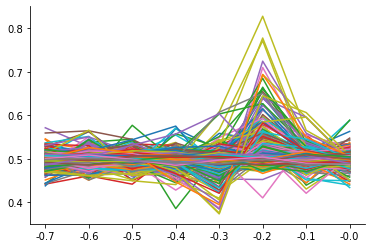

In [24]:
dt = 0.1
xt = np.array(range(tap))*dt

# for ON cells
info_on = sta_info[sta_info['cell type'] == 'ON']
idx_on = info_on.index
# on_spike_counts = spike_counts[idx_on,:]
# on_spike_counts.shape
for i in idx_on:
    spike_triggered_stim, spike_count = grab_spike_triggered_stim(stim.T, spike_counts[i,:], tap=tap)
    sta = np.average(np.array(spike_triggered_stim), weights=spike_count, axis=0)
    plt.plot(xt, sta.T)
    plt.xticks(xt, labels=['{:.1f}'.format(-x) for x in xt[::-1]])
# len(spike_triggered_stim)
# plt.hist(spike_count)

# plt.legend(info_on['channel name'], loc='upper left')
# plt.ylim((0.45,0.55))
remove_box()

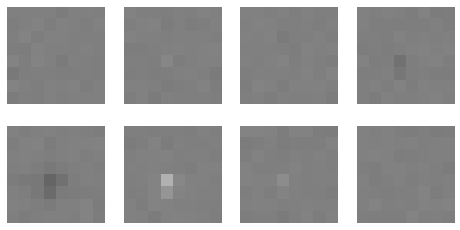

In [25]:
pysta.plot_stim_slices(sta)

In [26]:
def calc_and_plot_sta(stim, spike_counts, tap, dt=0.2, labels=None):
    xt = np.array(range(tap))*dt
    
    for i in range(spike_counts.shape[0]):
        spike_triggered_stim, spike_count = grab_spike_triggered_stim(stim, spike_counts[i,:], tap=tap)
        sta = np.average(np.array(spike_triggered_stim), weights=spike_count, axis=0)
        plt.plot(xt, sta.T)
        plt.xticks(xt, labels=['{:.1f}'.format(-x) for x in xt[::-1]])

    plt.xlabel('time to spike')
    plt.ylabel('STA')
    
    if labels is not None:
        if len(labels)<10:
            plt.legend(labels, loc='upper left')
            

    remove_box()

In [27]:
tap = 6

# STA for ON cells
info_on = info[info['cell_type'] == 'ON']
spike_counts_on = spike_counts[info_on.index,:]
    
calc_and_plot_sta(stim, spike_counts_on, tap=tap, dt=0.2, labels=info_on['channel_name'])
plt.ylim((0.45,0.55))

plt.title('ON RGCs')

info_on

NameError: name 'info' is not defined

In [46]:
# STA for OFF cells
info_off = info[info['cell_type'] == 'OFF']
spike_counts_off = spike_counts[info_off.index,:]
    
calc_and_plot_sta(stim, spike_counts_off, tap=tap, dt=0.2, labels=info_off['channel_name'])
plt.ylim((0.45,0.55))

plt.title('OFF RGCs')

info_off

NameError: name 'info' is not defined

In [ ]:
# STA for ON-OFF cells
info_on_off = info[info['cell_type'] == 'ON-OFF']
spike_counts_on_off = spike_counts[info_on_off.index,:]
    
calc_and_plot_sta(stim, spike_counts_on_off, tap=tap, dt=0.2, labels=info_on_off['channel_name'])
plt.ylim((0.45,0.55))

plt.title('ON-OFF RGCs')

info_on

In [ ]:
# one more abstraction!
def plot_sta_by_cell_type(info, spike_counts, key='cell_type', key_value='ON'):
    info_on_off = info[info[key] == key_value]
    spike_counts_on_off = spike_counts[info_on_off.index,:]

    calc_and_plot_sta(stim, spike_counts_on_off, tap=tap, dt=0.2, labels=info_on_off['channel_name'])
    plt.ylim((0.45,0.55))

    plt.title('{} RGCs'.format(key_value))

    info_on
    
plt.figure(figsize=(15,4))
plt.subplot(131)    
plot_sta_by_cell_type(info, spike_counts, 'cell_type', 'ON')
plt.subplot(132)    
plot_sta_by_cell_type(info, spike_counts, 'cell_type', 'OFF')
plt.subplot(133)    
plot_sta_by_cell_type(info, spike_counts, 'cell_type', 'ON-OFF')

plt.savefig('sta_by_cell_type_c{}.png'.format(contrast))